## **1. Importing Necessary Libraries**







In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import random
import pandas as pd
import torch
import torch.nn as nn

## **2. Definition des propriétés relatives au volant de badminton**

In [ ]:
# Constantes
g = 9.81  # gravité (m/s^2)
air_density = 1.2  # densité de l'air (kg/m^3)
drag_coefficient = 0.5  # coefficient de traînée
cross_sectional_area = 0.00363  # surface de section transversale (m^2)
m = 0.005  # masse du volant (kg)


𝑔
=
9
,
81
g=9,81 : C'est l'accélération due à la gravité sur Terre, exprimée en mètres par seconde carrée (
m/s
2
m/s
2
 ). Elle exerce une force vers le bas sur le volant.

𝑚
=
0
,
005
m=0,005 : La masse du volant, en kilogrammes (
kg
kg). Cette valeur est essentielle pour calculer son impulsion et son interaction avec des forces comme la gravité et la traînée.

𝐶
𝑑
=
0
,
5
C
d
​
 =0,5 : Le coefficient de traînée. Il représente l'aérodynamisme du volant dans l'air. Une valeur de 0,5 indique un objet relativement peu aérodynamique, typique d'un volant de badminton.

𝐴
=
0
,
003
A=0,00363 : La surface de section transversale du volant, exprimée en mètres carrés (
m
2
m
2
 ). Cette surface est utilisée pour calculer la force de traînée subie par le volant lorsqu'il se déplace dans l'air.

## **3. simulation de la data**

In [ ]:
# === Étape 1 : Génération des données (Trajectoire simulée du volant) ===
def generate_shuttlecock_data(num_samples=1000, noise_std=0.01):
    """
    Génère des données synthétiques 2D pour la trajectoire du volant basées sur les équations physiques.
    :param num_samples: Nombre d'échantillons à générer.
    :param noise_std: Écart type du bruit à ajouter.
    :return: temps et données (contenant les positions x et y en fonction du temps).
    """
    # Conditions initiales
    v0 = 30.0  # vitesse initiale (m/s)
    angle = np.radians(40)  # angle de lancement (converti de degrés en radians)
    vx0 = v0 * np.cos(angle)  # vitesse initiale dans la direction x
    vy0 = v0 * np.sin(angle)  # vitesse initiale dans la direction y

    # Tableau de temps
    t = np.linspace(0, 2.5, num_samples)  # simulation sur 2,5 secondes
    dt = t[1] - t[0]  # intervalle de temps entre les échantillons

    # Initialisation des positions et vitesses
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    vx = vx0
    vy = vy0

    for i in range(1, len(t)):
        # Calcul de la force de traînée
        v = np.sqrt(vx**2 + vy**2)  # vitesse totale
        drag_force = 0.5 * air_density * drag_coefficient * cross_sectional_area * v**2
        drag_acceleration = drag_force / m  # accélération due à la traînée

        # Mise à jour des vitesses
        vx -= drag_acceleration * (vx / v) * dt
        vy -= (g + drag_acceleration * (vy / v)) * dt

        # Mise à jour des positions
        x[i] = x[i - 1] + vx * dt
        y[i] = y[i - 1] + vy * dt

        # Arrêt de la simulation si le volant touche le sol
        if y[i] < 0:
            x = x[:i]
            y = y[:i]
            t = t[:i]
            break

    # Ajout de bruit
    x += np.random.normal(0, noise_std, size=x.shape)
    y += np.random.normal(0, noise_std, size=y.shape)

    # Combinaison de x et y dans un tableau unique
    data = np.stack((x, y), axis=1)

    return t, data

# Génération des données
time, data = generate_shuttlecock_data()


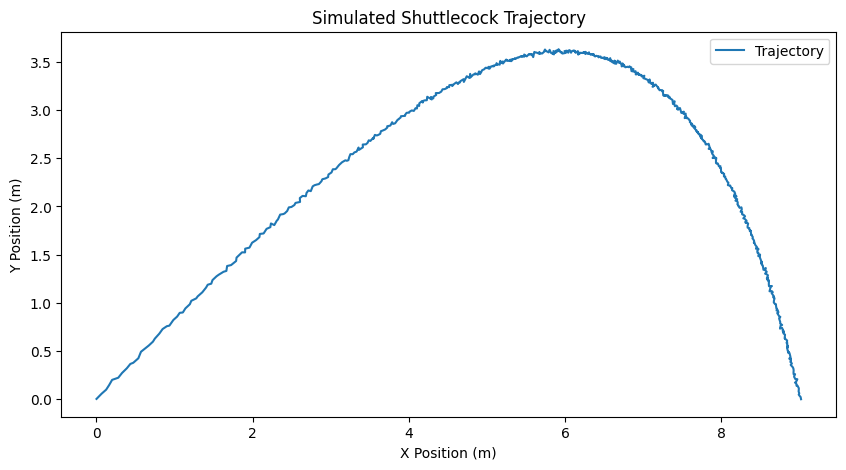

In [ ]:
# Visualize data
plt.figure(figsize=(10, 5))
plt.plot(data[:, 0], data[:, 1], label="Trajectory")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Simulated Shuttlecock Trajectory")
plt.legend()
plt.show()

obtenir les tensors à utiliser pour l'entraiment du modele

In [ ]:
# Simulated trajectory
outputs_train = torch.tensor(data, dtype=torch.float32)  # The corresponding data

t_train = torch.tensor(time, dtype=torch.float32).view(-1, 1)

## **4. First trial : Define PiNN Model**

In [226]:
# Define PiNN model with one hidden layer
class ShuttlecockPiNN(nn.Module):
    def __init__(self):
        super(ShuttlecockPiNN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 256),  # Single hidden layer with 256 neurons
            nn.Sigmoid(),
            nn.Linear(256, 4)  # Outputs: x, y, v_x, v_y
        )
        self.C = 0.5  # Drag coefficient

    def forward(self, t):
        return self.hidden(t)

    def compute_ux(self, x_in):
        # Compute Jacobian for the input x_in
        return torch.autograd.functional.jacobian(self, x_in, create_graph=True)

    def compute_physics_loss(self, t, outputs):
        x, y, v_x, v_y = outputs[:, 0], outputs[:, 1], outputs[:, 2], outputs[:, 3]

        # Compute derivatives using autograd
        v_pred = torch.sqrt(v_x**2 + v_y**2)  # Speed magnitude
        ax = torch.autograd.grad(v_x.sum(), t, create_graph=True)[0]
        ay = torch.autograd.grad(v_y.sum(), t, create_graph=True)[0]

        # Physics constraints: Drag and gravity forces
        fx = -self.C * v_pred * v_x
        fy = -g - self.C * v_pred * v_y

        # Physics loss (difference between predicted and calculated physics)
        physics_loss = torch.mean((ax - fx) ** 2 + (ay - fy) ** 2)
        return physics_loss

    def compute_total_loss(self, t, outputs, targets, lambda_reg=1.0):
        # Compute data loss and physics-informed regularization
        data_loss = torch.mean((outputs[:, :2] - targets) ** 2)
        physics_loss = self.compute_physics_loss(t, outputs)
        return data_loss+physics_loss


# Instantiate the model
model = ShuttlecockPiNN()

In [ ]:
torch.mean((predictions[:, :2] - outputs_train) ** 2)

tensor(0.0120, grad_fn=<MeanBackward0>)

In [227]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [228]:
outputs_train

tensor([[ 7.6641e-01, -5.0101e-03],
        [-2.4506e+00, -7.5109e-01],
        [-5.1909e-01,  1.2348e+00],
        [ 1.2618e+00, -1.1214e+00],
        [ 1.0305e+00, -1.6281e-01],
        [-3.0733e-01,  1.7745e+00],
        [ 9.7062e-01,  1.1755e+00],
        [-4.6941e-01, -1.1199e-01],
        [-5.1958e-01, -1.6682e+00],
        [-1.6222e-01, -3.2481e-01],
        [-8.6987e-01, -2.7236e-01],
        [ 3.7012e-01, -9.6989e-01],
        [-1.2672e+00,  5.2779e-01],
        [ 4.5495e-01,  3.2885e-01],
        [-4.4648e-01, -2.6216e+00],
        [ 5.2139e-01,  4.6720e-01],
        [ 5.8657e-01, -6.8636e-01],
        [-4.9322e-01,  1.2119e+00],
        [-9.6876e-01, -8.9275e-01],
        [-9.9390e-01,  3.6879e-01],
        [ 1.0731e+00, -6.2473e-01],
        [ 8.4139e-02, -8.9635e-01],
        [ 1.3111e+00,  2.2350e-01],
        [-8.4247e-02,  7.8714e-01],
        [ 4.7135e-01, -5.6156e-02],
        [ 5.1980e-01, -1.1210e+00],
        [-5.1200e-01, -5.9469e-01],
        [ 4.9121e-01, -1.076

## **5.Training Loop**

Epoch 0, Loss: 99.45299530029297
Epoch 100, Loss: 0.848916232585907
Epoch 200, Loss: 0.8237370848655701
Epoch 300, Loss: 0.823516309261322
Epoch 400, Loss: 0.8232983946800232
Epoch 500, Loss: 0.8230903148651123
Epoch 600, Loss: 0.8228919506072998
Epoch 700, Loss: 0.822701632976532
Epoch 800, Loss: 0.8225166201591492
Epoch 900, Loss: 0.8223342299461365
Epoch 1000, Loss: 0.8221524357795715
Epoch 1100, Loss: 0.8219698071479797
Epoch 1200, Loss: 0.8217855095863342
Epoch 1300, Loss: 0.8215989470481873
Epoch 1400, Loss: 0.8214093446731567
Epoch 1500, Loss: 0.8212160468101501
Epoch 1600, Loss: 0.8210179209709167
Epoch 1700, Loss: 0.8208131790161133
Epoch 1800, Loss: 0.8205999135971069
Epoch 1900, Loss: 0.8203798532485962
Epoch 2000, Loss: 0.820160984992981
Epoch 2100, Loss: 0.819927990436554
Epoch 2200, Loss: 0.8196864724159241
Epoch 2300, Loss: 0.8194217085838318
Epoch 2400, Loss: 0.8191345930099487
Epoch 2500, Loss: 0.8188158869743347
Epoch 2600, Loss: 0.8184704780578613
Epoch 2700, Loss: 0

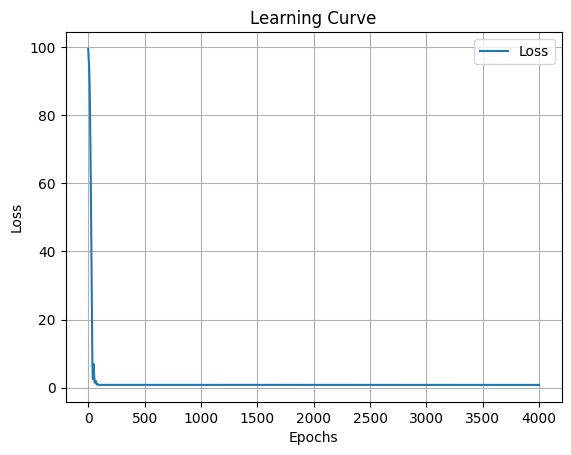

In [229]:
import matplotlib.pyplot as plt

# Variables pour stocker l'historique des pertes
loss_history = []

# Training loop
epochs = 4000
for epoch in range(epochs):
    optimizer.zero_grad()
    t_train.requires_grad = True  # Enable gradient computation for time
    predictions = model(t_train)
    loss = model.compute_total_loss(t_train, predictions, outputs_train)
    loss.backward()
    optimizer.step()

    # Sauvegarde de la perte pour chaque époque
    loss_history.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Plotting the learning curve
plt.plot(range(epochs), loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


In [194]:
predictions[:, :2]

tensor([[0.6147, 0.6165],
        [0.6411, 0.6358],
        [0.6675, 0.6551],
        ...,
        [9.0546, 0.3491],
        [9.0599, 0.3396],
        [9.0651, 0.3302]], grad_fn=<SliceBackward0>)

In [ ]:
outputs_train

tensor([[ 2.3342e-03,  2.8503e-03],
        [ 6.7253e-02,  5.6833e-02],
        [ 1.2589e-01,  9.8890e-02],
        ...,
        [ 9.0038e+00,  3.3165e-02],
        [ 9.0156e+00,  2.2564e-02],
        [ 9.0210e+00, -2.4383e-04]])

In [ ]:
from torchsummary import summary

# Print summary of the model
summary(model, input_size=(1,))  # The input is a single feature (1,)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]             512
           Sigmoid-2                  [-1, 256]               0
            Linear-3                    [-1, 4]           1,028
Total params: 1,540
Trainable params: 1,540
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


## **6.Visualization of True vs Predicted Shuttlecock Trajectory**

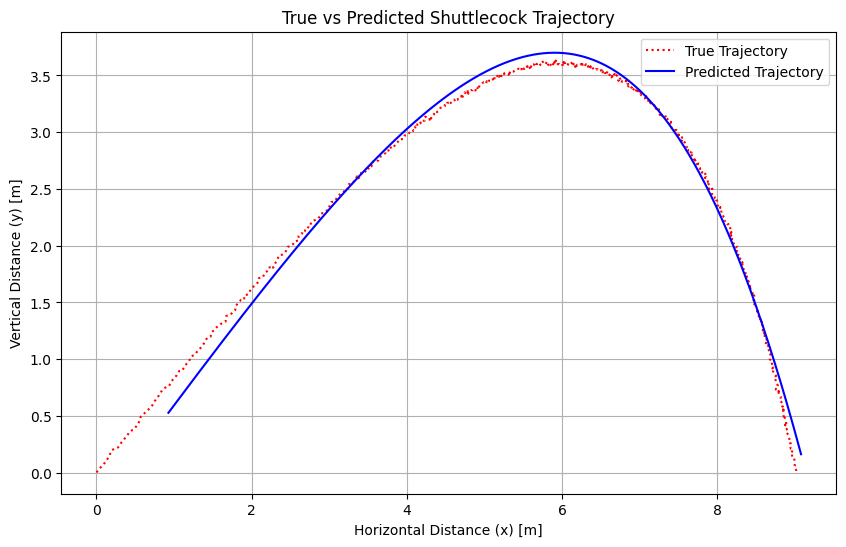

In [ ]:
# Visualize results
predicted = model(t_train).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(data[:, 0], data[:, 1], label="True Trajectory", linestyle='dotted', color='red')
plt.plot(predicted[:, 0], predicted[:, 1], label="Predicted Trajectory", linestyle='solid', color='blue')
plt.xlabel("Horizontal Distance (x) [m]")
plt.ylabel("Vertical Distance (y) [m]")
plt.title("True vs Predicted Shuttlecock Trajectory")
plt.legend()
plt.grid()
plt.show()


1 ère Optimisation: cross validation (avec kFold) et grid search sur le nombre de nuerones,la fonction d'ativation et le learning rate)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [164]:
import optuna
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import KFold
import numpy as np

# Define the Optuna objective function with cross-validation
def objective(trial):
    # Hyperparameters to tune
    num_neurons = trial.suggest_categorical('num_neurons', [128, 256, 512])  # Number of neurons in the hidden layer
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)  # Learning rate
    activation_fn = trial.suggest_categorical('activation_fn', ['ReLU', 'Tanh', 'Sigmoid'])  # Activation function choice

    # Define the model with 1 hidden layer
    class CustomShuttlecockPiNN(nn.Module):
        def __init__(self, activation_fn):
            super(CustomShuttlecockPiNN, self).__init__()
            layers = []
            layers.append(nn.Linear(1, num_neurons))  # First layer (input -> hidden)

            # Choose activation function based on tuning
            if activation_fn == 'ReLU':
                layers.append(nn.ReLU())  # ReLU activation
            elif activation_fn == 'Tanh':
                layers.append(nn.Tanh())  # Tanh activation
            elif activation_fn == 'Sigmoid':
                layers.append(nn.Sigmoid())  # Sigmoid activation

            layers.append(nn.Linear(num_neurons, 4))  # Output layer (hidden -> output)
            self.hidden = nn.Sequential(*layers)
            self.C = 0.5  # Drag coefficient

        def forward(self, t):
            t.requires_grad_()  # Ensure t requires gradients
            return self.hidden(t)

        def compute_physics_loss(self, t, outputs):
            t.requires_grad_()  # Ensure t requires gradients
            x, y, v_x, v_y = outputs[:, 0], outputs[:, 1], outputs[:, 2], outputs[:, 3]
            v_pred = torch.sqrt(v_x**2 + v_y**2)  # Compute speed
            ax = torch.autograd.grad(v_x.sum(), t, create_graph=True)[0]  # Ensure we can compute gradients w.r.t. t
            ay = torch.autograd.grad(v_y.sum(), t, create_graph=True)[0]  # Same for ay
            g = 9.81  # Gravity constant (m/s²)
            fx = -self.C * v_pred * v_x  # Drag force in x-direction
            fy = -g - self.C * v_pred * v_y  # Drag force in y-direction
            physics_loss = torch.mean((ax - fx) ** 2 + (ay - fy) ** 2)
            return physics_loss

        def compute_total_loss(self, t, outputs, targets, lambda_reg=1.0):
            t.requires_grad_()  # Ensure t requires gradients
            # Compute data loss and physics-informed regularization
            data_loss = torch.mean((outputs[:, :2] - targets) ** 2)  # Loss for x and y
            physics_loss = self.compute_physics_loss(t, outputs)  # Physics-informed loss
            return data_loss+physics_loss

    # Assume `t_train` and `outputs_train` are already defined and properly set
    t_train = torch.randn(100, 1)  # Example random data (replace with actual training data)
    outputs_train = torch.randn(100, 2)  # Example random targets (replace with actual targets)

    # Set requires_grad for inputs
    t_train.requires_grad_()  # Ensure t_train requires gradients

    kfold = KFold(n_splits=5, shuffle=True)  # 5-fold cross-validation
    total_loss = 0  # To store the average loss across folds

    for train_idx, val_idx in kfold.split(t_train):
        # Split data into training and validation sets for each fold
        t_train_fold, t_val_fold = t_train[train_idx], t_train[val_idx]
        outputs_train_fold, outputs_val_fold = outputs_train[train_idx], outputs_train[val_idx]

        # Instantiate the model with the chosen activation function
        model = CustomShuttlecockPiNN(activation_fn)

        # Define optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        epochs = 1000  # Number of epochs for each fold
        for epoch in range(epochs):
            optimizer.zero_grad()
            t_train_fold.requires_grad_()  # Ensure t_train_fold requires gradients
            predictions = model(t_train_fold)
            loss = model.compute_total_loss(t_train_fold, predictions, outputs_train_fold)
            loss.backward(retain_graph=True)  # Retain the graph to allow multiple backward passes
            optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")

        # Validate the model on the validation set (using the trained model)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # No gradient calculation for validation
            predictions_val = model(t_val_fold)
            loss_val = model.compute_total_loss(t_val_fold, predictions_val, outputs_val_fold)
            total_loss += loss_val.item()

    # Return the average loss from cross-validation
    avg_loss = total_loss / kfold.get_n_splits()
    return avg_loss  # Optuna will use this to find the best hyperparameters

# Create an Optuna study
study = optuna.create_study(direction='minimize')  # We want to minimize the loss
study.optimize(objective, n_trials=10)  # Optimize for 10 trials

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best trial's loss: ", study.best_value)


[I 2025-01-21 12:19:03,015] A new study created in memory with name: no-name-fa7ea662-96e9-43c2-9378-312148ec7722
<ipython-input-164-46bf2ebf2f1c>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)  # Learning rate


Epoch 0, Loss: 1.1223136186599731
Epoch 100, Loss: 1.0825769901275635
Epoch 200, Loss: 1.0544438362121582
Epoch 300, Loss: 1.0346578359603882
Epoch 400, Loss: 1.0206869840621948
Epoch 500, Loss: 1.0108609199523926
Epoch 600, Loss: 1.0040463209152222
Epoch 700, Loss: 0.9993899464607239
Epoch 800, Loss: 0.9962226152420044
Epoch 900, Loss: 0.9940347671508789
Epoch 0, Loss: 1.2035400867462158
Epoch 100, Loss: 1.1331146955490112
Epoch 200, Loss: 1.0754700899124146
Epoch 300, Loss: 1.0289115905761719
Epoch 400, Loss: 0.9918109178543091
Epoch 500, Loss: 0.962689995765686
Epoch 600, Loss: 0.9401944875717163
Epoch 700, Loss: 0.923102080821991
Epoch 800, Loss: 0.9103342294692993
Epoch 900, Loss: 0.900962233543396
Epoch 0, Loss: 1.2132279872894287
Epoch 100, Loss: 1.1480945348739624
Epoch 200, Loss: 1.1013065576553345
Epoch 300, Loss: 1.0691176652908325
Epoch 400, Loss: 1.0479447841644287
Epoch 500, Loss: 1.0346872806549072
Epoch 600, Loss: 1.0268033742904663
Epoch 700, Loss: 1.0223462581634521
E

[I 2025-01-21 12:19:09,351] Trial 0 finished with value: 1.0168532490730287 and parameters: {'num_neurons': 128, 'learning_rate': 1.520743883962967e-05, 'activation_fn': 'Tanh'}. Best is trial 0 with value: 1.0168532490730287.


Epoch 900, Loss: 0.9667436480522156
Epoch 0, Loss: 1.2258429527282715
Epoch 100, Loss: 1.130818486213684
Epoch 200, Loss: 1.0785614252090454
Epoch 300, Loss: 1.0488967895507812
Epoch 400, Loss: 1.0311393737792969
Epoch 500, Loss: 1.0199720859527588
Epoch 600, Loss: 1.0124355554580688
Epoch 700, Loss: 1.0068888664245605
Epoch 800, Loss: 1.0025019645690918
Epoch 900, Loss: 0.998881459236145
Epoch 0, Loss: 1.24398934841156
Epoch 100, Loss: 1.167437195777893
Epoch 200, Loss: 1.1342005729675293
Epoch 300, Loss: 1.117347002029419
Epoch 400, Loss: 1.1080920696258545
Epoch 500, Loss: 1.1025545597076416
Epoch 600, Loss: 1.0986883640289307
Epoch 700, Loss: 1.0955356359481812
Epoch 800, Loss: 1.0927197933197021
Epoch 900, Loss: 1.0901222229003906
Epoch 0, Loss: 1.2243871688842773
Epoch 100, Loss: 1.1446216106414795
Epoch 200, Loss: 1.1021842956542969
Epoch 300, Loss: 1.0797224044799805
Epoch 400, Loss: 1.0667307376861572
Epoch 500, Loss: 1.0580451488494873
Epoch 600, Loss: 1.051503300666809
Epoch

[I 2025-01-21 12:19:17,435] Trial 1 finished with value: 1.0921563625335693 and parameters: {'num_neurons': 256, 'learning_rate': 2.0820496749001387e-05, 'activation_fn': 'ReLU'}. Best is trial 0 with value: 1.0168532490730287.


Epoch 900, Loss: 0.9735028147697449
Epoch 0, Loss: 1.1406269073486328
Epoch 100, Loss: 1.0155584812164307
Epoch 200, Loss: 0.9955927729606628
Epoch 300, Loss: 0.9923065304756165
Epoch 400, Loss: 0.9903119206428528
Epoch 500, Loss: 0.9886679649353027
Epoch 600, Loss: 0.9873199462890625
Epoch 700, Loss: 0.9862297177314758
Epoch 800, Loss: 0.9853517413139343
Epoch 900, Loss: 0.9846380352973938
Epoch 0, Loss: 1.2580822706222534
Epoch 100, Loss: 1.1198382377624512
Epoch 200, Loss: 1.0892202854156494
Epoch 300, Loss: 1.083091139793396
Epoch 400, Loss: 1.0798901319503784
Epoch 500, Loss: 1.0773268938064575
Epoch 600, Loss: 1.0752005577087402
Epoch 700, Loss: 1.07346510887146
Epoch 800, Loss: 1.0720720291137695
Epoch 900, Loss: 1.070960283279419
Epoch 0, Loss: 1.1453427076339722
Epoch 100, Loss: 1.0449892282485962
Epoch 200, Loss: 1.0250753164291382
Epoch 300, Loss: 1.0151755809783936
Epoch 400, Loss: 1.0089280605316162
Epoch 500, Loss: 1.0052413940429688
Epoch 600, Loss: 1.0032227039337158
Ep

[I 2025-01-21 12:19:24,081] Trial 2 finished with value: 1.0305726051330566 and parameters: {'num_neurons': 512, 'learning_rate': 1.4317541062812098e-05, 'activation_fn': 'Sigmoid'}. Best is trial 0 with value: 1.0168532490730287.


Epoch 900, Loss: 0.9761465787887573
Epoch 0, Loss: 1.2044917345046997
Epoch 100, Loss: 1.16526198387146
Epoch 200, Loss: 1.1334259510040283
Epoch 300, Loss: 1.1079896688461304
Epoch 400, Loss: 1.0879278182983398
Epoch 500, Loss: 1.072277307510376
Epoch 600, Loss: 1.0601942539215088
Epoch 700, Loss: 1.0509212017059326
Epoch 800, Loss: 1.0438005924224854
Epoch 900, Loss: 1.038312554359436
Epoch 0, Loss: 1.376194715499878
Epoch 100, Loss: 1.3426005840301514
Epoch 200, Loss: 1.3156378269195557
Epoch 300, Loss: 1.2938193082809448
Epoch 400, Loss: 1.2758278846740723
Epoch 500, Loss: 1.2606772184371948
Epoch 600, Loss: 1.2477238178253174
Epoch 700, Loss: 1.2365648746490479
Epoch 800, Loss: 1.2269184589385986
Epoch 900, Loss: 1.218577265739441
Epoch 0, Loss: 1.2345927953720093
Epoch 100, Loss: 1.209378957748413
Epoch 200, Loss: 1.192675232887268
Epoch 300, Loss: 1.1817567348480225
Epoch 400, Loss: 1.1746540069580078
Epoch 500, Loss: 1.1700568199157715
Epoch 600, Loss: 1.1670398712158203
Epoch 

[I 2025-01-21 12:19:31,992] Trial 3 finished with value: 1.2073113203048706 and parameters: {'num_neurons': 128, 'learning_rate': 1.2005825955269839e-05, 'activation_fn': 'ReLU'}. Best is trial 0 with value: 1.0168532490730287.


Epoch 0, Loss: 0.9904772639274597
Epoch 100, Loss: 0.8585559725761414
Epoch 200, Loss: 0.8546246290206909
Epoch 300, Loss: 0.8511160612106323
Epoch 400, Loss: 0.8482279777526855
Epoch 500, Loss: 0.8459385633468628
Epoch 600, Loss: 0.8441858291625977
Epoch 700, Loss: 0.8428937792778015
Epoch 800, Loss: 0.8419766426086426
Epoch 900, Loss: 0.8413466215133667
Epoch 0, Loss: 0.9316738247871399
Epoch 100, Loss: 0.8086913824081421
Epoch 200, Loss: 0.8035773038864136
Epoch 300, Loss: 0.7991016507148743
Epoch 400, Loss: 0.7954143285751343
Epoch 500, Loss: 0.7924383878707886
Epoch 600, Loss: 0.7900814414024353
Epoch 700, Loss: 0.7882534861564636
Epoch 800, Loss: 0.7868596911430359
Epoch 900, Loss: 0.7858020067214966
Epoch 0, Loss: 1.0119051933288574
Epoch 100, Loss: 0.8702497482299805
Epoch 200, Loss: 0.8653593063354492
Epoch 300, Loss: 0.8609132766723633
Epoch 400, Loss: 0.857172966003418
Epoch 500, Loss: 0.8540655374526978
Epoch 600, Loss: 0.8514782190322876
Epoch 700, Loss: 0.8493248224258423

[I 2025-01-21 12:19:39,121] Trial 4 finished with value: 0.8925165653228759 and parameters: {'num_neurons': 512, 'learning_rate': 5.919237038363878e-05, 'activation_fn': 'Tanh'}. Best is trial 4 with value: 0.8925165653228759.


Epoch 0, Loss: 1.168587327003479
Epoch 100, Loss: 1.0639152526855469
Epoch 200, Loss: 1.042323350906372
Epoch 300, Loss: 1.0264337062835693
Epoch 400, Loss: 1.0124306678771973
Epoch 500, Loss: 1.0002288818359375
Epoch 600, Loss: 0.9897292852401733
Epoch 700, Loss: 0.980787456035614
Epoch 800, Loss: 0.9732385873794556
Epoch 900, Loss: 0.9669114947319031
Epoch 0, Loss: 0.9563239216804504
Epoch 100, Loss: 0.9174430966377258
Epoch 200, Loss: 0.9138997197151184
Epoch 300, Loss: 0.9105029106140137
Epoch 400, Loss: 0.9073868989944458
Epoch 500, Loss: 0.9046503305435181
Epoch 600, Loss: 0.9023219347000122
Epoch 700, Loss: 0.9003877639770508
Epoch 800, Loss: 0.8988045454025269
Epoch 900, Loss: 0.8975140452384949
Epoch 0, Loss: 0.9942960739135742
Epoch 100, Loss: 0.9305685758590698
Epoch 200, Loss: 0.922892689704895
Epoch 300, Loss: 0.9159927368164062
Epoch 400, Loss: 0.9099728465080261
Epoch 500, Loss: 0.9049107432365417
Epoch 600, Loss: 0.9007171392440796
Epoch 700, Loss: 0.897231936454773
Epo

[I 2025-01-21 12:19:46,071] Trial 5 finished with value: 1.0340312838554382 and parameters: {'num_neurons': 128, 'learning_rate': 8.299009630465996e-05, 'activation_fn': 'Tanh'}. Best is trial 4 with value: 0.8925165653228759.


Epoch 0, Loss: 1.1301590204238892
Epoch 100, Loss: 0.9411358833312988
Epoch 200, Loss: 0.934207558631897
Epoch 300, Loss: 0.933364987373352
Epoch 400, Loss: 0.9325319528579712
Epoch 500, Loss: 0.931692898273468
Epoch 600, Loss: 0.9308484792709351
Epoch 700, Loss: 0.9299958944320679
Epoch 800, Loss: 0.9291313290596008
Epoch 900, Loss: 0.9282503128051758
Epoch 0, Loss: 1.0393569469451904
Epoch 100, Loss: 0.974704384803772
Epoch 200, Loss: 0.9719764590263367
Epoch 300, Loss: 0.9693816900253296
Epoch 400, Loss: 0.9670248031616211
Epoch 500, Loss: 0.9648691415786743
Epoch 600, Loss: 0.9628325700759888
Epoch 700, Loss: 0.960837185382843
Epoch 800, Loss: 0.9588247537612915
Epoch 900, Loss: 0.9567564725875854
Epoch 0, Loss: 1.1639988422393799
Epoch 100, Loss: 1.110399842262268
Epoch 200, Loss: 1.1084554195404053
Epoch 300, Loss: 1.106481909751892
Epoch 400, Loss: 1.104472041130066
Epoch 500, Loss: 1.102402687072754
Epoch 600, Loss: 1.1002517938613892
Epoch 700, Loss: 1.098000168800354
Epoch 80

[I 2025-01-21 12:19:52,119] Trial 6 finished with value: 1.0840210676193238 and parameters: {'num_neurons': 128, 'learning_rate': 9.699128354836055e-05, 'activation_fn': 'Tanh'}. Best is trial 4 with value: 0.8925165653228759.


Epoch 0, Loss: 1.1625843048095703
Epoch 100, Loss: 1.1255733966827393
Epoch 200, Loss: 1.1233258247375488
Epoch 300, Loss: 1.1229040622711182
Epoch 400, Loss: 1.1226210594177246
Epoch 500, Loss: 1.1224329471588135
Epoch 600, Loss: 1.1223039627075195
Epoch 700, Loss: 1.1222057342529297
Epoch 800, Loss: 1.1221215724945068
Epoch 900, Loss: 1.1220418214797974
Epoch 0, Loss: 1.094137191772461
Epoch 100, Loss: 0.9774017333984375
Epoch 200, Loss: 0.9393634796142578
Epoch 300, Loss: 0.9289718866348267
Epoch 400, Loss: 0.9251754879951477
Epoch 500, Loss: 0.9226926565170288
Epoch 600, Loss: 0.9206241369247437
Epoch 700, Loss: 0.9188786745071411
Epoch 800, Loss: 0.9174415469169617
Epoch 900, Loss: 0.9162889719009399
Epoch 0, Loss: 1.2751282453536987
Epoch 100, Loss: 1.1353586912155151
Epoch 200, Loss: 1.0822865962982178
Epoch 300, Loss: 1.0681726932525635
Epoch 400, Loss: 1.0655486583709717
Epoch 500, Loss: 1.0650947093963623
Epoch 600, Loss: 1.0649187564849854
Epoch 700, Loss: 1.0647822618484497

[I 2025-01-21 12:19:59,428] Trial 7 finished with value: 1.0744677662849427 and parameters: {'num_neurons': 256, 'learning_rate': 1.662833278640092e-05, 'activation_fn': 'Sigmoid'}. Best is trial 4 with value: 0.8925165653228759.


Epoch 0, Loss: 1.1075568199157715
Epoch 100, Loss: 1.0791707038879395
Epoch 200, Loss: 1.0623036623001099
Epoch 300, Loss: 1.052704095840454
Epoch 400, Loss: 1.0472629070281982
Epoch 500, Loss: 1.0441334247589111
Epoch 600, Loss: 1.0422437191009521
Epoch 700, Loss: 1.0409682989120483
Epoch 800, Loss: 1.039970874786377
Epoch 900, Loss: 1.039095163345337
Epoch 0, Loss: 1.038024663925171
Epoch 100, Loss: 1.0084633827209473
Epoch 200, Loss: 0.9857279062271118
Epoch 300, Loss: 0.9687496423721313
Epoch 400, Loss: 0.9564483761787415
Epoch 500, Loss: 0.9478195905685425
Epoch 600, Loss: 0.9419635534286499
Epoch 700, Loss: 0.9381089210510254
Epoch 800, Loss: 0.9356300234794617
Epoch 900, Loss: 0.934049129486084
Epoch 0, Loss: 1.2061575651168823
Epoch 100, Loss: 1.1715624332427979
Epoch 200, Loss: 1.1466772556304932
Epoch 300, Loss: 1.128430962562561
Epoch 400, Loss: 1.1150810718536377
Epoch 500, Loss: 1.1054327487945557
Epoch 600, Loss: 1.0985219478607178
Epoch 700, Loss: 1.0935604572296143
Epoc

[I 2025-01-21 12:20:05,839] Trial 8 finished with value: 1.0481784224510193 and parameters: {'num_neurons': 128, 'learning_rate': 1.0818246332114719e-05, 'activation_fn': 'Sigmoid'}. Best is trial 4 with value: 0.8925165653228759.


Epoch 900, Loss: 1.0195565223693848
Epoch 0, Loss: 1.1252301931381226
Epoch 100, Loss: 0.9959856271743774
Epoch 200, Loss: 0.9337701797485352
Epoch 300, Loss: 0.9081581234931946
Epoch 400, Loss: 0.8980620503425598
Epoch 500, Loss: 0.8932622671127319
Epoch 600, Loss: 0.8901067972183228
Epoch 700, Loss: 0.8875582814216614
Epoch 800, Loss: 0.8853076696395874
Epoch 900, Loss: 0.8832744359970093
Epoch 0, Loss: 0.9998041391372681
Epoch 100, Loss: 0.9513216018676758
Epoch 200, Loss: 0.9355367422103882
Epoch 300, Loss: 0.9287614822387695
Epoch 400, Loss: 0.9246255159378052
Epoch 500, Loss: 0.9212724566459656
Epoch 600, Loss: 0.9182636141777039
Epoch 700, Loss: 0.9155281782150269
Epoch 800, Loss: 0.9130241274833679
Epoch 900, Loss: 0.9107508659362793
Epoch 0, Loss: 0.9290519952774048
Epoch 100, Loss: 0.8436650037765503
Epoch 200, Loss: 0.8128509521484375
Epoch 300, Loss: 0.8021261096000671
Epoch 400, Loss: 0.7976938486099243
Epoch 500, Loss: 0.7950078845024109
Epoch 600, Loss: 0.792946219444274

[I 2025-01-21 12:20:12,991] Trial 9 finished with value: 0.948773980140686 and parameters: {'num_neurons': 256, 'learning_rate': 2.211492745875488e-05, 'activation_fn': 'ReLU'}. Best is trial 4 with value: 0.8925165653228759.


Epoch 900, Loss: 0.9277957081794739
Best hyperparameters:  {'num_neurons': 512, 'learning_rate': 5.919237038363878e-05, 'activation_fn': 'Tanh'}
Best trial's loss:  0.8925165653228759


**Training the best model**

In [175]:
# L1 regularization term
def l1_regularization(model, lambda_l1):
    l1_norm = 0.0
    for param in model.parameters():
        l1_norm += torch.sum(torch.abs(param))
    return lambda_l1 * l1_norm

In [176]:
# L2 regularization term
def l2_regularization(model, lambda_l2):
    l2_norm = 0.0
    for param in model.parameters():
        l2_norm += torch.sum(param**2)
    return lambda_l2 * l2_norm

In [199]:
# Define PiNN model with one hidden layer
class ShuttlecockPiNN(nn.Module):
    def __init__(self):
        super(ShuttlecockPiNN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 512),  # Single hidden layer with 512 neurons
            nn.Tanh(),
            nn.Linear(512, 4)  # Outputs: x, y, v_x, v_y
        )
        self.C = 0.5  # Drag coefficient

    def forward(self, t):
        return self.hidden(t)

    def compute_ux(self, x_in):
        # Compute Jacobian for the input x_in
        return torch.autograd.functional.jacobian(self, x_in, create_graph=True)

    def compute_physics_loss(self, t, outputs):
        x, y, v_x, v_y = outputs[:, 0], outputs[:, 1], outputs[:, 2], outputs[:, 3]

        # Compute derivatives using autograd
        v_pred = torch.sqrt(v_x**2 + v_y**2)  # Speed magnitude
        ax = torch.autograd.grad(v_x.sum(), t, create_graph=True)[0]
        ay = torch.autograd.grad(v_y.sum(), t, create_graph=True)[0]

        # Physics constraints: Drag and gravity forces
        fx = -self.C * v_pred * v_x
        fy = -g - self.C * v_pred * v_y

        # Physics loss (difference between predicted and calculated physics)
        physics_loss = torch.mean((ax - fx) ** 2 + (ay - fy) ** 2)
        return physics_loss

    def compute_total_loss(self, t, outputs, targets, lambda_reg=1.0, lambda_l1=0.001, lambda_l2=0.001):
      # Compute data loss and physics-informed regularization
      data_loss = torch.mean((outputs[:, :2] - targets) ** 2)  # Loss for x and y
      physics_loss = self.compute_physics_loss(t, outputs)  # Physics-informed loss

      # Add L1 and L2 regularization
      l1_loss = l1_regularization(self, lambda_l1)
      l2_loss = l2_regularization(self, lambda_l2)

      total_loss = data_loss + physics_loss + l1_loss + l2_loss
      return total_loss


# Instantiate the model
model = ShuttlecockPiNN()

In [203]:
optimizer = optim.Adam(model.parameters(), lr=5.919237038363878e-05)

Epoch 0, Loss: 0.8561352491378784
Epoch 100, Loss: 0.8546992540359497
Epoch 200, Loss: 0.8546708822250366
Epoch 300, Loss: 0.8546391129493713
Epoch 400, Loss: 0.8546018004417419
Epoch 500, Loss: 0.8545594811439514
Epoch 600, Loss: 0.8545135259628296
Epoch 700, Loss: 0.8544636964797974
Epoch 800, Loss: 0.8544090390205383
Epoch 900, Loss: 0.8543514609336853
Epoch 1000, Loss: 0.8542891144752502
Epoch 1100, Loss: 0.8542285561561584
Epoch 1200, Loss: 0.8541703224182129
Epoch 1300, Loss: 0.8541091084480286
Epoch 1400, Loss: 0.8540471196174622
Epoch 1500, Loss: 0.853996217250824
Epoch 1600, Loss: 0.8539444208145142
Epoch 1700, Loss: 0.8538932800292969
Epoch 1800, Loss: 0.8538404107093811
Epoch 1900, Loss: 0.8537835478782654
Epoch 2000, Loss: 0.8537216782569885
Epoch 2100, Loss: 0.8536582589149475
Epoch 2200, Loss: 0.853589653968811
Epoch 2300, Loss: 0.853516161441803
Epoch 2400, Loss: 0.8534390926361084
Epoch 2500, Loss: 0.8533586859703064
Epoch 2600, Loss: 0.853272020816803
Epoch 2700, Loss:

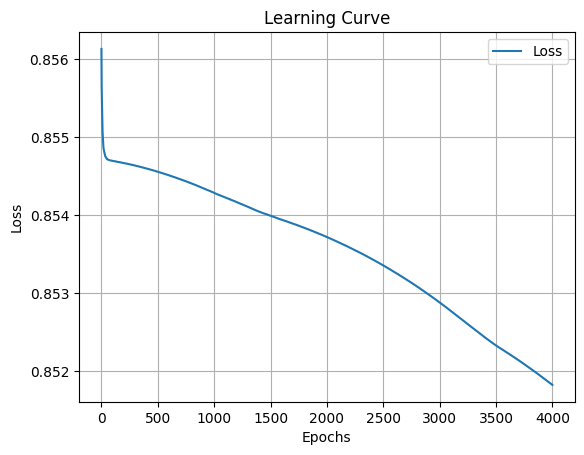

In [204]:
import matplotlib.pyplot as plt

# Variables pour stocker l'historique des pertes
loss_history = []

# Training loop
epochs = 4000
for epoch in range(epochs):
    optimizer.zero_grad()
    t_train.requires_grad = True  # Enable gradient computation for time
    predictions = model(t_train)
    loss = model.compute_total_loss(t_train, predictions, outputs_train)
    loss.backward()
    optimizer.step()

    # Sauvegarde de la perte pour chaque époque
    loss_history.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Plotting the learning curve
plt.plot(range(epochs), loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

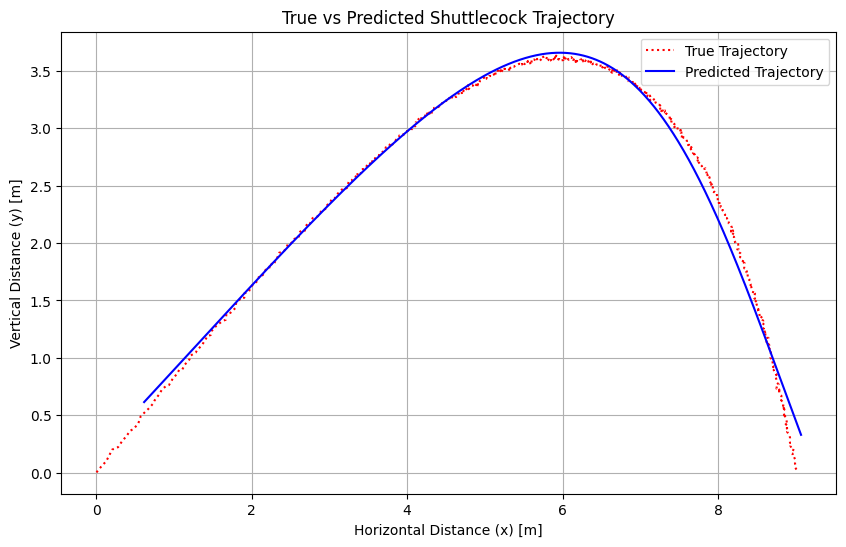

In [186]:
# Visualize results
predicted = model(t_train).detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(data[:, 0], data[:, 1], label="True Trajectory", linestyle='dotted', color='red')
plt.plot(predicted[:, 0], predicted[:, 1], label="Predicted Trajectory", linestyle='solid', color='blue')
plt.xlabel("Horizontal Distance (x) [m]")
plt.ylabel("Vertical Distance (y) [m]")
plt.title("True vs Predicted Shuttlecock Trajectory")
plt.legend()
plt.grid()
plt.show()

## **8.Evalution**
### 1.RMSE

In [230]:
import torch
import time
from tabulate import tabulate

def evaluate_model(predictions, outputs_train):
    """
    Evaluate the model's performance on metrics like MAE, RMSE, accuracy, FP, FN, and inference latency.

    Args:
    - predictions: The predicted outputs from the model (e.g., predicted positions).
    - outputs_train: The true outputs (target trajectory values).

    Returns:
    - A string formatted as a beautiful table displaying the evaluation results.
    """
    # Measure inference latency
    start_time = time.time()

    # Calculate Mean Absolute Error (MAE)
    mae = torch.mean(torch.abs(predictions[:, :2] - outputs_train[:, :2])).item()

    # Calculate Root Mean Squared Error (RMSE)
    rmse = torch.sqrt(torch.mean((predictions[:, :2] - outputs_train[:, :2]) ** 2)).item()

    # Calculate accuracy
    correct = torch.sum(torch.all(torch.abs(predictions[:, :2] - outputs_train[:, :2]) < 0.1, dim=1)).item()
    accuracy = correct / predictions.shape[0]

    # Measure latency
    latency = time.time() - start_time

    # Compare the predicted and true values for FP and FN
    threshold = 0.5  # Set your threshold for considering a positive detection
    predicted_class = (predictions[:, :2] > threshold).int()  # Predicted values converted to binary based on threshold
    true_class = (outputs_train[:, :2] > threshold).int()  # True values converted to binary based on threshold

    # Calculate False Positives (FP) and False Negatives (FN)
    false_positive = torch.sum((predicted_class == 1) & (true_class == 0)).item()
    false_negative = torch.sum((predicted_class == 0) & (true_class == 1)).item()

    # Prepare the result for display in a table
    results = [
        ["Mean Absolute Error (MAE)", round(mae, 4)],
        ["Root Mean Squared Error (RMSE)", round(rmse, 4)],
        ["Accuracy (%)", round(accuracy * 100, 2)],
        ["False Positives (FP)", false_positive],
        ["False Negatives (FN)", false_negative],
        ["Inference Latency (seconds)", round(latency, 4)]
    ]

    # Format the results as a table
    table = tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid")

    return table


# Evaluate the model
evaluation_table = evaluate_model(predictions, outputs_train)
print(evaluation_table)


╒════════════════════════════════╤═════════╕
│ Metric                         │   Value │
╞════════════════════════════════╪═════════╡
│ Mean Absolute Error (MAE)      │  0.7366 │
├────────────────────────────────┼─────────┤
│ Root Mean Squared Error (RMSE) │  0.901  │
├────────────────────────────────┼─────────┤
│ Accuracy (%)                   │  1      │
├────────────────────────────────┼─────────┤
│ False Positives (FP)           │  0      │
├────────────────────────────────┼─────────┤
│ False Negatives (FN)           │ 64      │
├────────────────────────────────┼─────────┤
│ Inference Latency (seconds)    │  0.0014 │
╘════════════════════════════════╧═════════╛
